##### Copyright 2019 The TensorFlow Authors.

# Deep Conditional Convolutional Generative Adversarial Network

In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.2.0-rc4'

In [0]:
# To generate GIFs
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras import Model
import time
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Embedding, LeakyReLU, Concatenate, BatchNormalization, concatenate, Activation
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout

from IPython import display

Using TensorFlow backend.


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
tfds.list_builders()
builder = tfds.builder("fashion_mnist")
builder.download_and_prepare()

In [0]:
print(builder.info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [0]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

In [0]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (28, 28))
  return image, label

In [0]:
train_dataset = train_dataset_raw.map(format_example)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

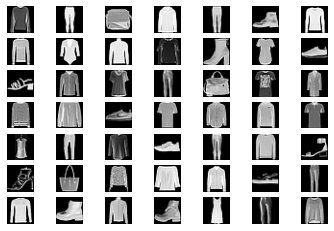

In [0]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1.0) / 2.0
  plt.imshow(image[:,:,0], cmap='gray')
  i = i + 1
  print(label)
plt.show()

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
# make your own generator model
def make_generator_model(n_classes):
  inputs = tf.keras.Input(shape=(1,))
  lat = tf.keras.Input(shape=(100,))

  li = layers.Embedding(n_classes, 50)(inputs)
  li = layers.Dense(7*7, use_bias=False)(li)
  li = layers.Reshape((7, 7, 1))(li)
  
  g = layers.Dense(128*7*7, use_bias=False)(lat)
  g = layers.LeakyReLU()(g)
  g = layers.Reshape((7, 7, 128))(g)
  
  merge = layers.Concatenate()([g, li])
  
  g = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  g = layers.LeakyReLU()(g)
  
  g = layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(g)
  g = layers.LeakyReLU(alpha=0.2)(g)

  outputs = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(g)
  model = tf.keras.Model(inputs=[lat, inputs], outputs=outputs)
  
  return model

Use the (as yet untrained) generator to create an image.

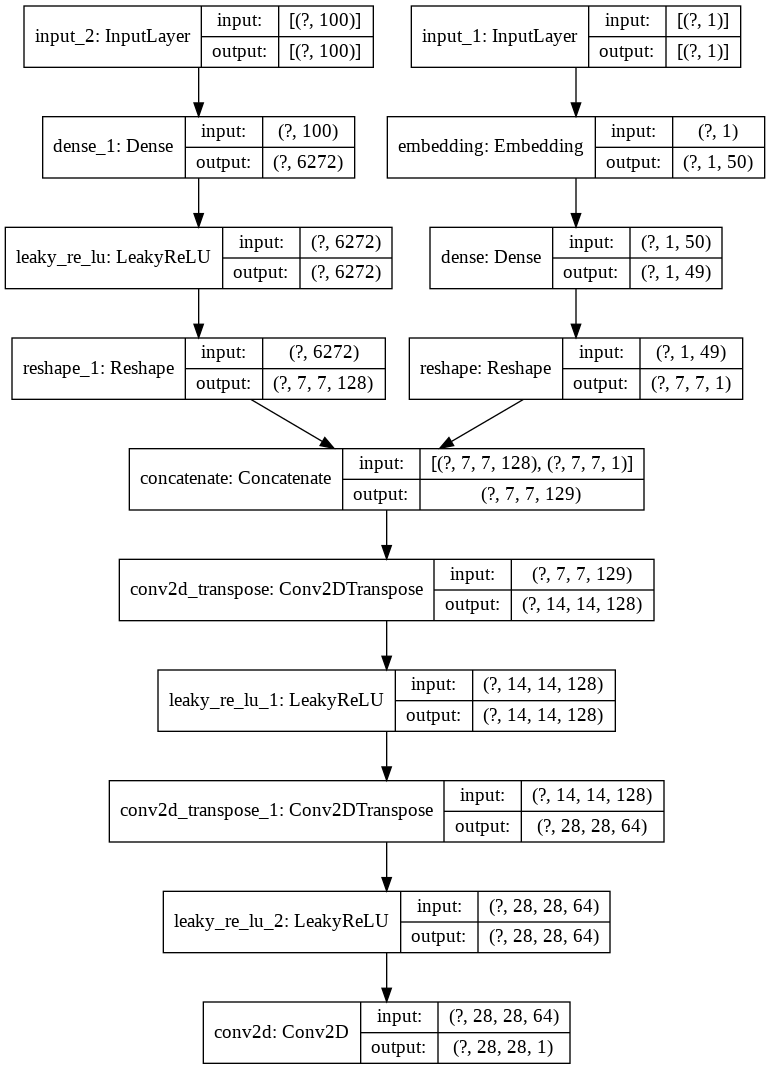

In [0]:
n_classes = 10
generator = make_generator_model(n_classes)
tf.keras.utils.plot_model(generator, show_shapes=True, to_file='generator.png')

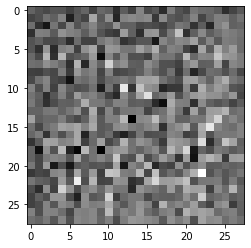

In [0]:
#generator.summary()
noise = tf.random.normal([1, 100])
from numpy.random import randint
noisy_label = randint(0, n_classes, 1)
generated_image = generator([noise, noisy_label], training=False)
plt.imshow((generated_image[0, :, :, 0] + 1) / 2, cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
#make your own discriminator model
def make_discriminator_model(n_classes):
  labels = tf.keras.Input(shape=(1,))
  images = tf.keras.Input(shape=(28, 28, 1))
  
  li = layers.Embedding(n_classes, 50)(labels)
  li = layers.Dense(28*28)(li)
  li = layers.Reshape((28, 28, 1))(li)
  
  merge = layers.Concatenate()([images, li])
  
  fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = layers.LeakyReLU()(fe)
  
  fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = layers.LeakyReLU()(fe)
  
  fe = layers.Flatten()(fe)
  fe = layers.Dropout(0.3)(fe)
  
  outputs = layers.Dense(1, activation='tanh')(fe)
  model = tf.keras.Model(inputs=[images, labels], outputs=outputs)
  
  return model

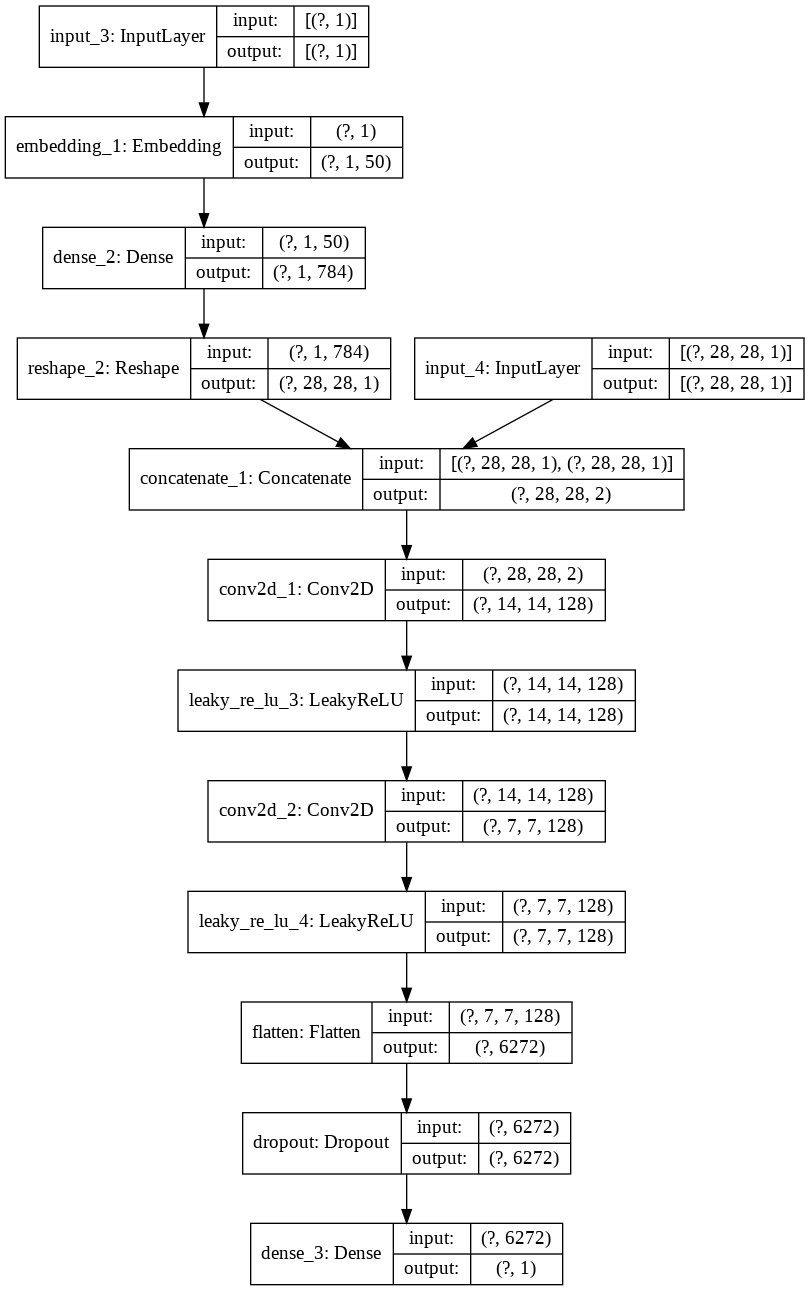

In [0]:
n_classes = 10
discriminator = make_discriminator_model(n_classes)
tf.keras.utils.plot_model(discriminator, show_shapes=True, to_file='discriminator.png')

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [0]:
#discriminator.summary()
from numpy.random import randint
label = randint(0, n_classes, 1)
print(label)

decision = discriminator([generated_image, label])
print (decision)

[9]
tf.Tensor([[0.00026251]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

metricsAcc=tf.keras.metrics.BinaryAccuracy()

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [0]:
noise_dim = 100
num_examples_to_generate = 100

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
from numpy import asarray
seed_images = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = asarray([x for _ in range(10) for x in range(10)])
print(seed_labels)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, labels):
    noise_image = tf.random.normal([BATCH_SIZE, noise_dim])
    noise_labels = label = randint(0, n_classes, BATCH_SIZE)
    #print("coming into the function")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      real_output = discriminator([images, labels], training=True)
      #print("salida con imagenes reales {:.5f}".format(tf.math.reduce_mean(real_output)))
      generated_images = generator([noise_image, noise_labels], training=True)
      fake_output = discriminator([generated_images, noise_labels], training=True)
      #print("salida con imagenes falsas {:.5f}".format(tf.math.reduce_mean(fake_output)))
      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    j = 0
    for image_batch, label_batch in dataset:
      #print(j)
      train_step(image_batch, label_batch)
      #j = j + 1

    print("A NEW EPOCH")
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed_images, seed_labels)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed_images, seed_labels)

**Generate and save images**


In [0]:
def generate_and_save_images(model, epoch, test_input_images, test_input_labels):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model([test_input_images, test_input_labels], training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      # scale [-1, 1] to [0, 1]
      image = (predictions[i, :, :, 0] + 1.0) / 2.0
      plt.imshow(image, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

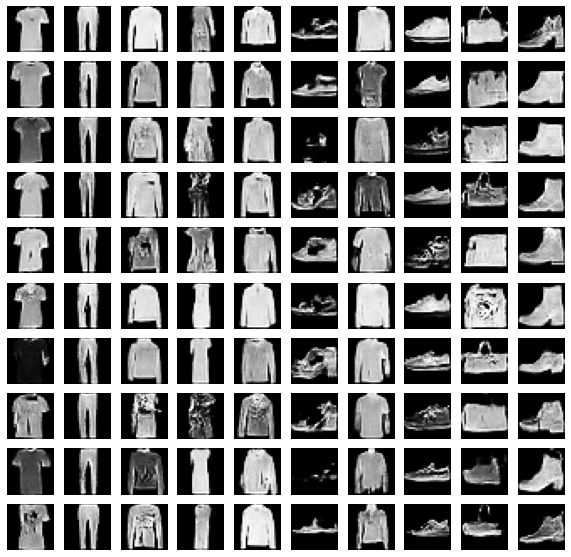

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset_shuffled, EPOCHS)

Restore the latest checkpoint.

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

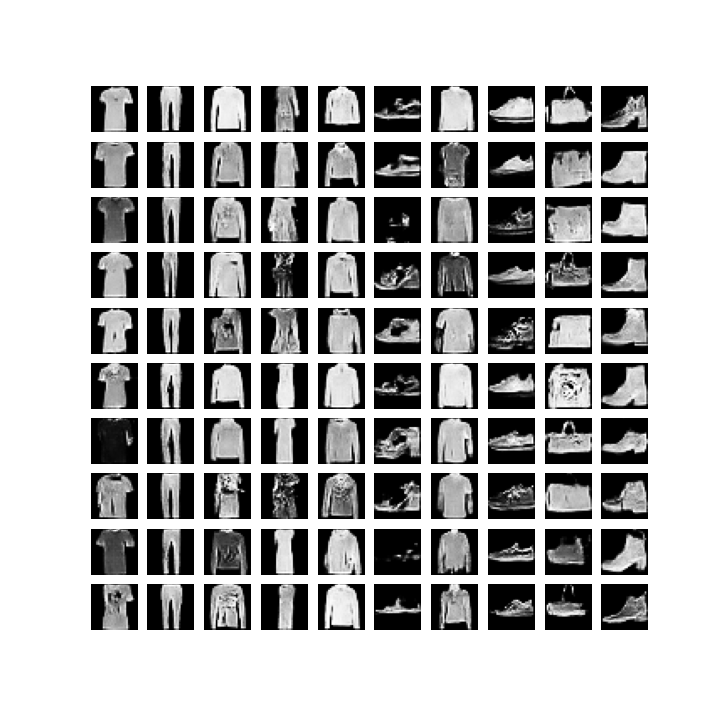

In [0]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)